# Bootleneck V.2 (Análisis por Año)

Después de haber entregado el análisis preliminar al cliente, en donde encontramos los valores del __flujo promedio limpio__ (en camiones por hora) para cada zona operacional, es momento de dar un vuelco y comenzar a procesar los datos conforme a encontrar patrones o indicadores de cuellos de botella dentro de CS. Para ello tomaremos la siguiente estructura.

1. Estructuración de los datos.
2. Calculo de estadísticos
3. Representación de estos. 

---

Para entender mejor la estructuración de los datos es necesario comprender ciertos objetivos y conceptos.

__Objetivo Principal__: Comprender el funcionamiento de la faena CS a través del análisis de los tiempos de espera y atención para cada Zona Operacional (ZO)

__Estrategia__: Buscar información en bloques de 30 minutos.

Tendremos 3 tipos de estatus:
1. Atención: cuando un camión se encuentra dentro de una ZO
2. Espera: cuando un camión está en espera o tránsito a una ZO
3. Out: Cuando el camión se encuentra fuera de la faena CS

Qué pretendemos encontrar en cada bloque establecido, para Atención y Espera?
1. N° de camiones que ingresaron y salieron de una ZO
2. N° de camiones que estaban en una ZO al inicio del bloque.
3. Tiempo acumulado de atención (SUM_i (t_i) = Tiempo acumulado).
4. Promedio, moda, media, max, min de tiempos de atención
5. Promedio, moda, media, max, min en el conteo de vehículos en Espera y Atención.

__Conceptos importantes__

1. __Tiempos de IDLE__: cuando tenemos una ZO inactiva y sin camiones en espera
2. __Tiempos de inactividad__: cuando tenemos una ZO inactiva y con camiones en espera
3. __Tiempos de Transición__: corresponden a los tiempos de salida y llegada de camiones (se estima que el máximo debe ser 5 min).


---

# 1. Estructuración de los datos 

Tomaremos en consideración los filtros aplicados en la sección de preprocesado, sin embargo añadiremos nuevas columnas omitidas en ese análisis, como lo son las columnas de "ZO Pre-Time", "ZO start", "ZO end" y quizás otra que consideremos importante para estos propósitos. 

Además,no eliminamos los viajes que van desde CS a CS, es decir los camiones que se encuentran en la misma faena todo el tiempo, debido a que se puede que sean partícipes del cuello de botella generado.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns

df = pd.read_csv("BoottleNeck_filtered_v2.csv", engine='python')
df = df.drop("Unnamed: 0",axis=1)
print(df.shape)
df.head()

(95254, 501)


Cycle Id  Year [In]  Month [In]  Day [In]  Hour [In]  Year [Out]  \
0  10242520       2019           6        30         15        2019   
1  10242540       2019           6        30         19        2019   
2  10527578       2019           6        30         23        2019   
3   9250786       2019           7         1          0        2019   
4   8143041       2019           7         1          0        2019   

   Month [Out]  Day [Out]  Hour [Out]     Origin  ... Zone Name (97)  \
0            6         30          16   Coya Sur  ...            NaN   
1            6         30          22  Tocopilla  ...            NaN   
2            7          1           0   Coya Sur  ...            NaN   
3            7          1           0   Coya Sur  ...            NaN   
4            7          1           0   Coya Sur  ...            NaN   

  Zone Pre Time (97)  Zone Start (97) Zone End (97) Zone Time (97)  \
0                NaN              NaN           NaN            NaN   
1                NaN              NaN           NaN            NaN   
2                NaN              NaN           NaN            NaN   
3                NaN              NaN           NaN            NaN   
4                NaN              NaN           NaN            NaN   

   Zone Name (98) Zone Pre Time (98)  Zone Start (98) Zone End (98)  \
0             NaN                NaN              NaN           NaN   
1             NaN                NaN              NaN           NaN   
2             NaN                NaN              NaN           NaN   
3             NaN                NaN              NaN           NaN   
4             NaN                NaN              NaN           NaN   

  Zone Time (98)  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  

[5 rows x 501 columns]

En esta oportunidad no nos enfocaremos en rutas en particular, solamente en las fechas de cada evento. Para ello utilizaremos los tiempos dados por Zone Start y Zone End. Además, despreciaremos las columnas de hora de entrada, hora salida, año entrada, año salida.

In [2]:
#cols = ["Year [In]","Year [Out]", "Hour [In]","Hour [Out]", "Origin", "Destination","Month [Out]"]
cols = ["Year [Out]", "Hour [In]","Hour [Out]","Month [Out]"]
df = df.drop(cols,axis=1)

#Convertimos Zone start y end en .time (hh:mm:ss)
for i in range(1,99):
    zone_1 = "Zone Start (%s)"%i
    zone_2 = "Zone End (%s)"%i
    df[zone_1] = pd.to_datetime(df[zone_1]).dt.time
    df[zone_2] = pd.to_datetime(df[zone_2]).dt.time
df

Cycle Id  Year [In]  Month [In]  Day [In]  Day [Out]            Origin  \
0      10242520       2019           6        30         30          Coya Sur   
1      10242540       2019           6        30         30         Tocopilla   
2      10527578       2019           6        30          1          Coya Sur   
3       9250786       2019           7         1          1          Coya Sur   
4       8143041       2019           7         1          1          Coya Sur   
...         ...        ...         ...       ...        ...               ...   
95249  18633231       2020           6         8          8    Nueva Victoria   
95250  18633167       2020           6         8          8          Coya Sur   
95251  18633133       2020           6         8          8    Nueva Victoria   
95252  18633510       2020           6         8          8  Salar de Atacama   
95253  18633550       2020           6         8          8  Salar de Atacama   

          Destination   Zone Name (1)  Zone Pre Time (1) Zone Start (1)  ...  \
0           Tocopilla  Romana Salitre              249.0       15:30:58  ...   
1            Coya Sur    C Secado L-4             5664.0       21:28:39  ...   
2            Coya Sur  Romana Salitre                0.0       23:59:34  ...   
3      Nueva Victoria           C PTS                0.0       00:00:09  ...   
4      Nueva Victoria          C NPT3              601.0       00:41:50  ...   
...               ...             ...                ...            ...  ...   
95249        Coya Sur             NaN                NaN            NaT  ...   
95250   Virtual_Place          C NPT3              760.0       05:45:18  ...   
95251        Coya Sur             NaN                NaN            NaT  ...   
95252        Coya Sur          C NPT3              715.0       05:46:43  ...   
95253        Coya Sur          C NPT3             1175.0       05:55:39  ...   

      Zone Name (97)  Zone Pre Time (97) Zone Start (97)  Zone End (97)  \
0                NaN                 NaN             NaT            NaT   
1                NaN                 NaN             NaT            NaT   
2                NaN                 NaN             NaT            NaT   
3                NaN                 NaN             NaT            NaT   
4                NaN                 NaN             NaT            NaT   
...              ...                 ...             ...            ...   
95249            NaN                 NaN             NaT            NaT   
95250            NaN                 NaN             NaT            NaT   
95251            NaN                 NaN             NaT            NaT   
95252            NaN                 NaN             NaT            NaT   
95253            NaN                 NaN             NaT            NaT   

      Zone Time (97) Zone Name (98)  Zone Pre Time (98) Zone Start (98)  \
0                NaN            NaN                 NaN             NaT   
1                NaN            NaN                 NaN             NaT   
2                NaN            NaN                 NaN             NaT   
3                NaN            NaN                 NaN             NaT   
4                NaN            NaN                 NaN             NaT   
...              ...            ...                 ...             ...   
95249            NaN            NaN                 NaN             NaT   
95250            NaN            NaN                 NaN             NaT   
95251            NaN            NaN                 NaN             NaT   
95252            NaN            NaN                 NaN             NaT   
95253            NaN            NaN                 NaN             NaT   

       Zone End (98) Zone Time (98)  
0                NaT            NaN  
1                NaT            NaN  
2                NaT            NaN  
3                NaT            NaN  
4                NaT            NaN  
...              ...            ...  
95249

La idea ahora es filtrar por horarios, es decir tener 48 bloques de media hora cada uno, es decir solo veremos las zonas que presentan entradas dentro de ese bloque, además ya no habrá distinción por número de zona, solo nos importará el nombre de ese lugar y sus datos.

In [3]:
def block_generator(inicio,fin):
    """Entregamos un rango de horas entre las cuales se quiere tener el bloque, 
       hr:min:seg > block >hr_:min_:seg_ """
    
    cont = 0
    for i in range(1,99):
        zone_1 = "Zone Name (%s)"%i
        zone_2 = "Zone Pre Time (%s)"%i
        zone_3 = "Zone Start (%s)"%i
        zone_4 = "Zone End (%s)"%i
        zone_5 = "Zone Time (%s)"%i

        cols=['Cycle Id', 'Origin', 'Destination', 'Year [In]','Month [In]', 'Day [In]', 'Day [Out]',
              zone_1, zone_2, zone_3, zone_4, zone_5]

        date_lower = datetime.time(inicio[0], inicio[1], inicio[2])
        date_upper = datetime.time(fin[0], fin[1], fin[2])
        a = df[(df[zone_3] < date_upper) & (df[zone_3] >= date_lower)] 
        b = a.loc[:,cols]
        b = b.rename(columns={zone_1:"Name ZO",
                          zone_2:"Pre Time",
                          zone_3:"Start",
                          zone_4:"End",
                          zone_5:"Time"})    
        if cont == 0:
            block = b
            cont += 1
            continue
        else:
            block = pd.concat([block, b], axis=0, sort=False) 
    block = block.sort_values(['Year [In]', 'Month [In]', 'Day [In]'], ascending=[True,True, True])
    return block

Generamos una función que nos muestre el bloque que hemos escogido, no tiene filtro en el tiempo de salida, se lo podemos agregar despues. Además, podemos filtrar por Fecha, si queremos ver por día o demás

In [22]:
inicio = [0,0,0]
fin =  [1,0,0]
Block=block_generator(inicio,fin)
Block

Cycle Id          Origin     Destination  Year [In]  Month [In]  \
2      10527578        Coya Sur        Coya Sur       2019           6   
3       9250786        Coya Sur  Nueva Victoria       2019           7   
4       8143041        Coya Sur  Nueva Victoria       2019           7   
3       9250786        Coya Sur  Nueva Victoria       2019           7   
4       8143041        Coya Sur  Nueva Victoria       2019           7   
...         ...             ...             ...        ...         ...   
95196  18628724  Nueva Victoria        Coya Sur       2020           6   
95197  18628463        Coya Sur  Nueva Victoria       2020           6   
95198  18628510        Coya Sur   Virtual_Place       2020           6   
95196  18628724  Nueva Victoria        Coya Sur       2020           6   
95198  18628510        Coya Sur   Virtual_Place       2020           6   

       Day [In]  Day [Out] Name ZO  Pre Time     Start       End    Time  
2            30          1  Salida       0.0  00:06:35  00:30:45  1450.0  
3             1          1   C PTS       0.0  00:00:09  00:05:52   343.0  
4             1          1  C NPT3     601.0  00:41:50  00:46:50   300.0  
3             1          1  Salida       0.0  00:05:52  00:10:10   258.0  
4             1          1  Salida       0.0  00:46:50  00:51:50   300.0  
...         ...        ...     ...       ...       ...       ...     ...  
95196         8          8  C NPT4       0.0  00:23:09  00:28:19   310.0  
95197         8          8  Salida       0.0  00:26:20  00:32:48   388.0  
95198         8          8  C NPT4       0.0  00:27:46  00:32:46   300.0  
95196         8          8  Salida       0.0  00:28:19  00:40:38   739.0  
95198         8          8  Salida       0.0  00:32:46  00:41:47   541.0  

[7019 rows x 12 columns]

# 2. Cálculo de estadísticos

Buscaremos algunas métricas que nos son importantes para el cliente tales como:

1. N° Vehículos que ingresaron y salieron de la ZO
2. N° Vehículos que estaban en una ZO al inicio
3. Tiempo acumulado de atención
4. Prom, Moda, Max, Min de los tiempos de atención
5. Prom, Max, Min, del conteo de vehículos en espera o atención.

Para realizar esto primero debemos definir los bloques de tiempo en los cuales analizaremos esto,ya sea  por mes, día, hora, minutos,etc.

---

## N° Vehículos que ingresaron y salieron de la ZO

Como primer aproach consideraremos el año completo, en bloques horario de 1 hr

In [5]:
#Vehiculos ingresados
def vehiculos_in(inicio=1,fin=25):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos ingresados} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(start,end)
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            vehiculos_in = block_filtered.shape[0]
            if zo in diccionario.keys():
                diccionario[zo].update({i:vehiculos_in})
            else:
                diccionario.update({zo:{i:vehiculos_in}})
    return diccionario


def dict_to_df(dictionary):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    count=0
    for k, v in dictionary.items():
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        if (count == 0):
            b=a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0)
    return b

Hemos creado 2 funciones que nos ayudarán a generar los bloques horarios por zona y además podemos convertir ese diccionario a un dataframe con fines más específicos

In [28]:
zonas_bloques=vehiculos_in()
heat_map_in=dict_to_df(zonas_bloques)

Crearemos un Mapa de calor que nos entregue una visión clara del suceso

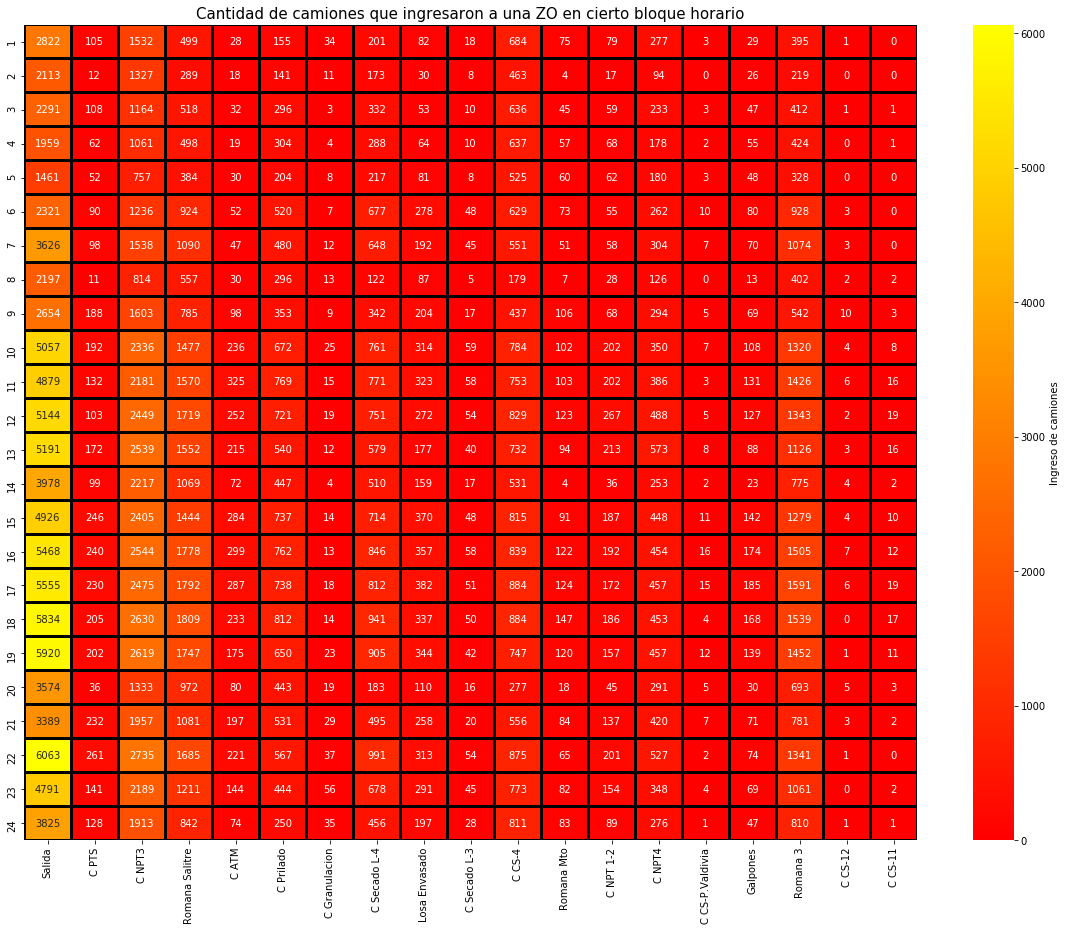

In [29]:
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(heat_map_in,cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Ingreso de camiones'},annot=True, fmt=".0f")
plt.title("Cantidad de camiones que ingresaron a una ZO en cierto bloque horario",fontsize=15)
plt.show()

Veamos el comportamiento sin la ZO salida, que sabemos que es la que presenta el mayor numero de camiones "ingresando" a esa ZO

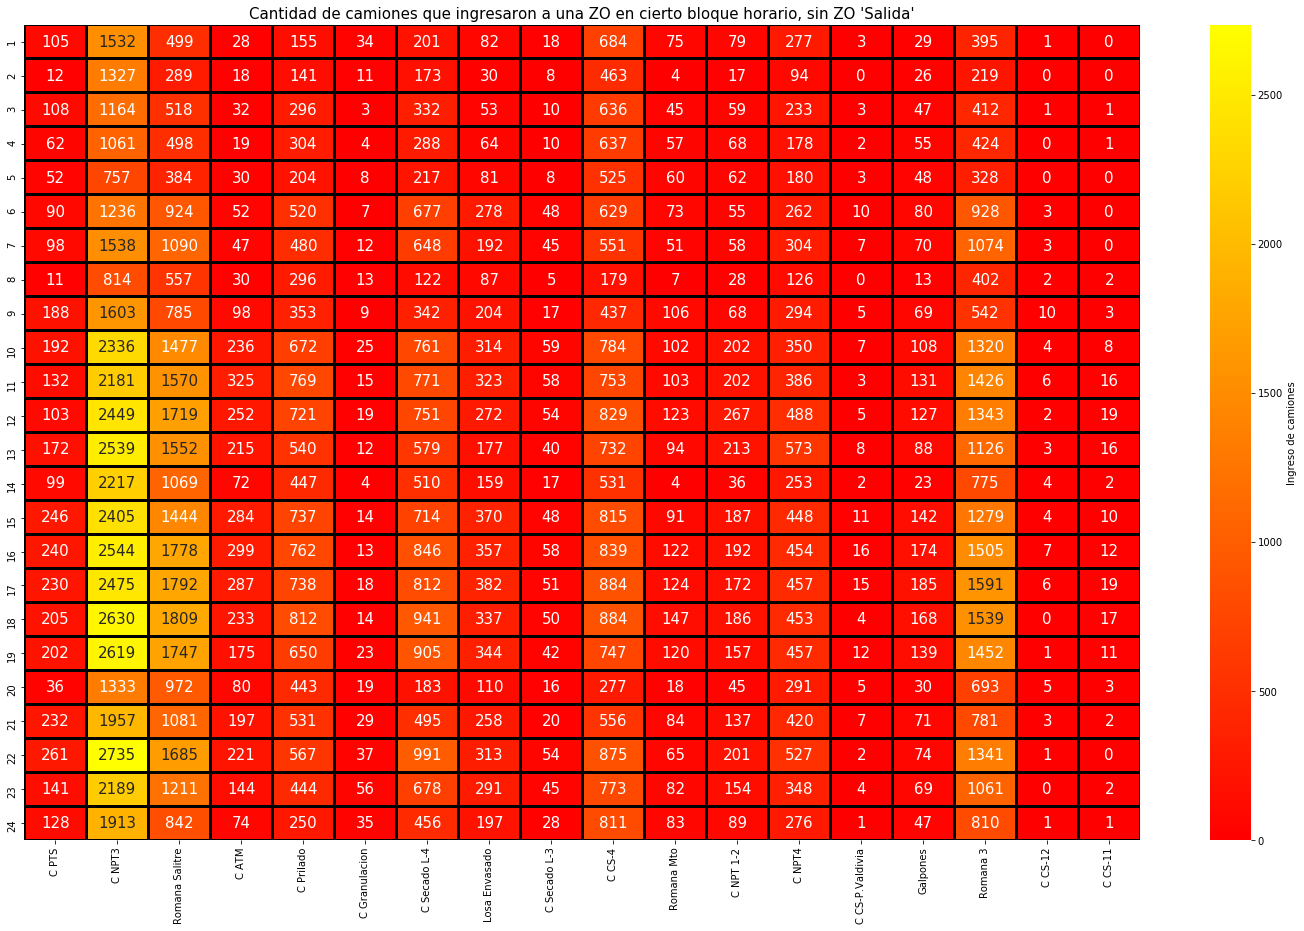

In [36]:
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_in.iloc[:,1:],cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Ingreso de camiones'},annot=True, fmt=".0f",annot_kws={"size": 15})
plt.title("Cantidad de camiones que ingresaron a una ZO en cierto bloque horario, sin ZO 'Salida'",fontsize=15)
plt.show()
#plt.savefig("Ingreso_camiones_hr.png")

In [ ]:
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_in.iloc[:,1:],cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Ingreso de camiones'},annot=True, fmt=".0f",annot_kws={"size": 15})
plt.title("Cantidad de camiones que ingresaron a una ZO en cierto bloque horario, sin ZO 'Salida'",fontsize=15)
plt.show()
#plt.savefig("Ingreso_camiones_hr.png")

Con este análisis podemos identificar las zonas operacionales que presentan mayor flujo de vehículos en qué bloques horario son más requeridas.

1. Las ZO más utilizadas son: C NPT3, Romana Salitre, Romana 3 (orden decreciente).
2. Los horarios más frecuentados se comprenden entre las 10 y 19 hrs


## Vehículos que salen de la ZO

In [33]:
#Vehiculos que salieron
def vehiculos_out(inicio=1,fin=25):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos salieron} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(start,end)
        date_lower = datetime.time(start[0], start[1], start[2])
        date_upper = datetime.time(end[0], end[1], end[2])
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            vehiculos_in = block_filtered.shape[0]
            if zo in diccionario.keys():
                diccionario[zo].update({i:vehiculos_in})
            else:
                diccionario.update({zo:{i:vehiculos_in}})
    return diccionario

zonas_bloques_out=vehiculos_out()
heat_map_out=dict_to_df(zonas_bloques_out)

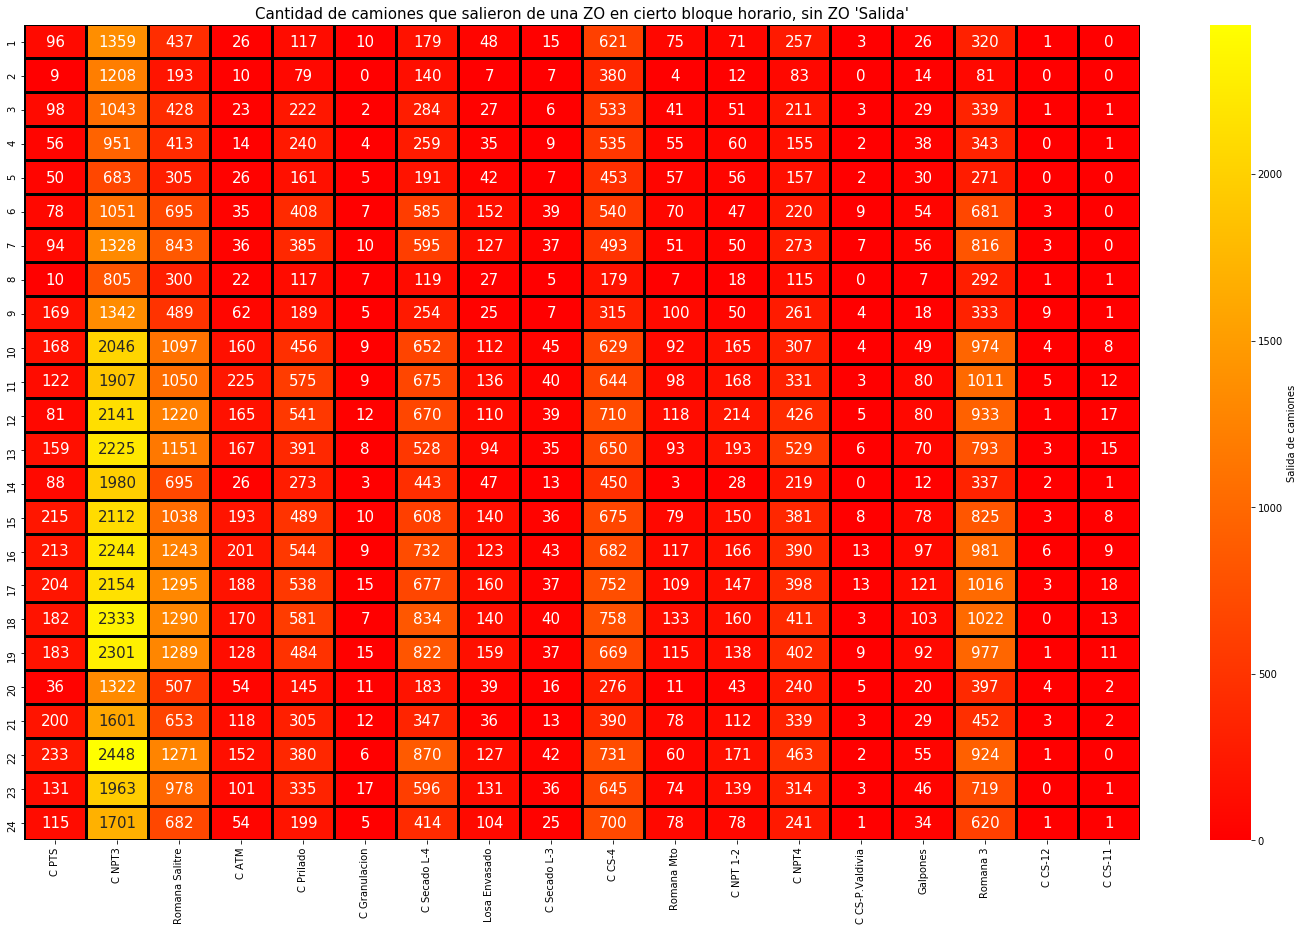

In [51]:
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_out.iloc[:,1:],cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Salida de camiones'},annot=True, fmt=".0f",annot_kws={"size": 15})
plt.title("Cantidad de camiones que salieron de una ZO en cierto bloque horario, sin ZO 'Salida'",fontsize=15)
plt.show()

## Vehículos que estaban en la Z0 al inicio del bloque horario

In [52]:
dif = heat_map_in - heat_map_out
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(dif.iloc[:,1:],cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Camiones al inicio'},annot=True, fmt=".0f",annot_kws={"size": 15})
plt.title("Cantidad de camiones que estaban en una ZO en al inicio de cierto bloque horario, sin ZO 'Salida'",fontsize=15)
plt.show()

Claramente este último Mapa de calor no nos dice mucho, aquí sin dudas es mejor tener un filtro por día o una ventana de tiempo más pequeña, ya que el año no me indica una posible problemática

## Tiempo acumulado de Atención

Procedemos a calcular el tiempo de atención, podemos considerar 2 opciones:
1. Los vehículos que salieron dentro del mismo bloque horario.
2. Los vehículos que no salieron dentro del mismo bloque horario, aquí puede que nos encontremos con anormalidades, camiones que se quedaron tiempos extremadamemte largos en la misma ZO

Analizaremos esto por separado.

### 1. Tiempo acumulado (vehículos que ingresaron y salieron en el mismo bloque)

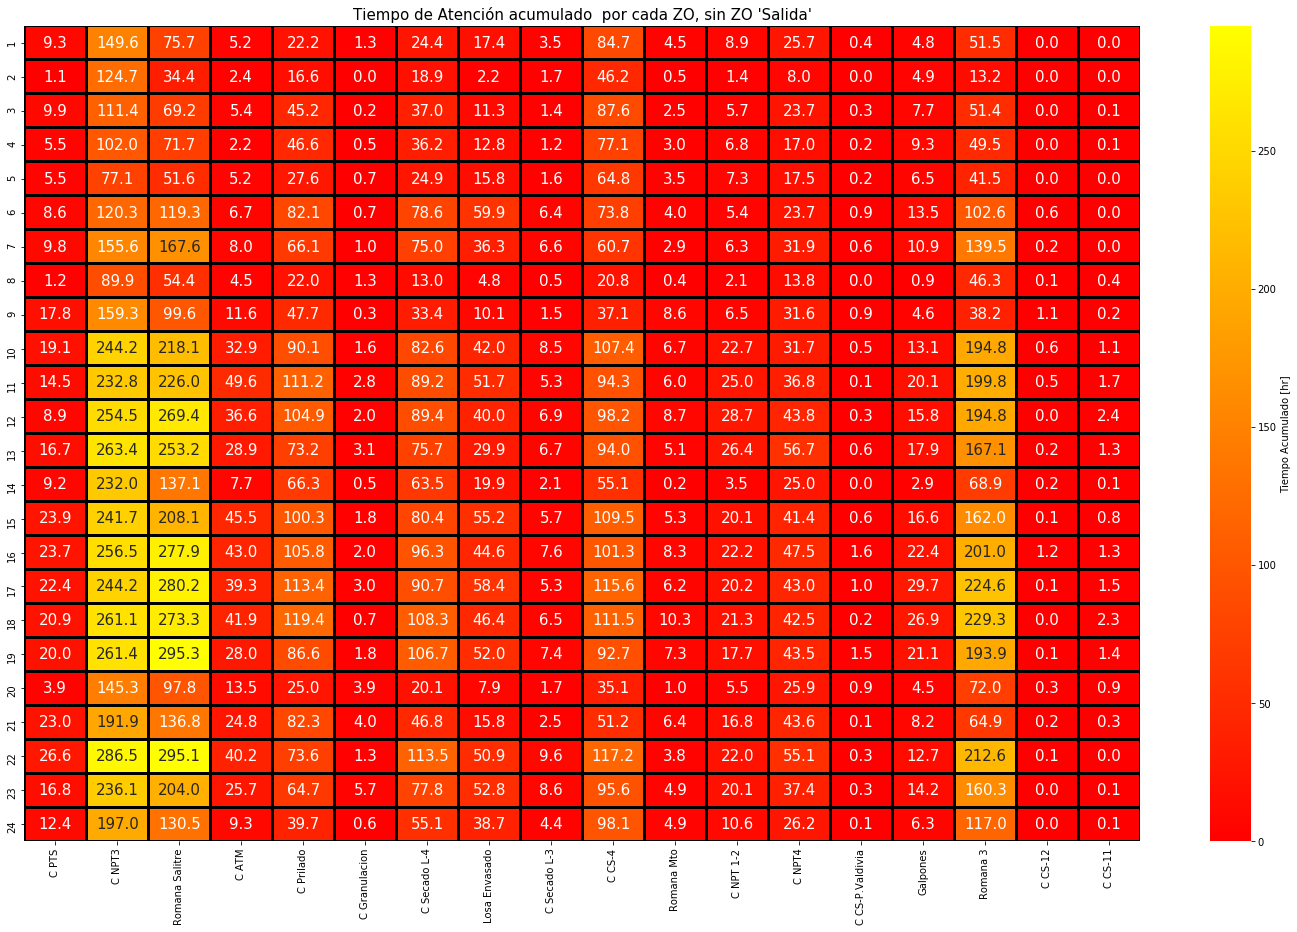

In [64]:
#Vehiculos que salieron, suma de tiempos
def vehiculos_time(inicio=1,fin=25):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos salieron} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(start,end)
        date_lower = datetime.time(start[0], start[1], start[2])
        date_upper = datetime.time(end[0], end[1], end[2])
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            cumulative_time = block_filtered.Time.sum()
            if zo in diccionario.keys():
                diccionario[zo].update({i:(cumulative_time/3600)})
            else:
                diccionario.update({zo:{i:(cumulative_time/3600)}})
    return diccionario

zonas_bloques_time=vehiculos_time()
heat_map_time=dict_to_df(zonas_bloques_time)
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_time.iloc[:,1:],cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Tiempo Acumulado [hr]'},annot=True, fmt=".1f",annot_kws={"size": 15})
plt.title("Tiempo de Atención acumulado  por cada ZO, sin ZO 'Salida'",fontsize=15)
plt.show()

### 2. Tiempo acumulado (vehículos que ingresaron y no necesariamente salieron en el mismo bloque)

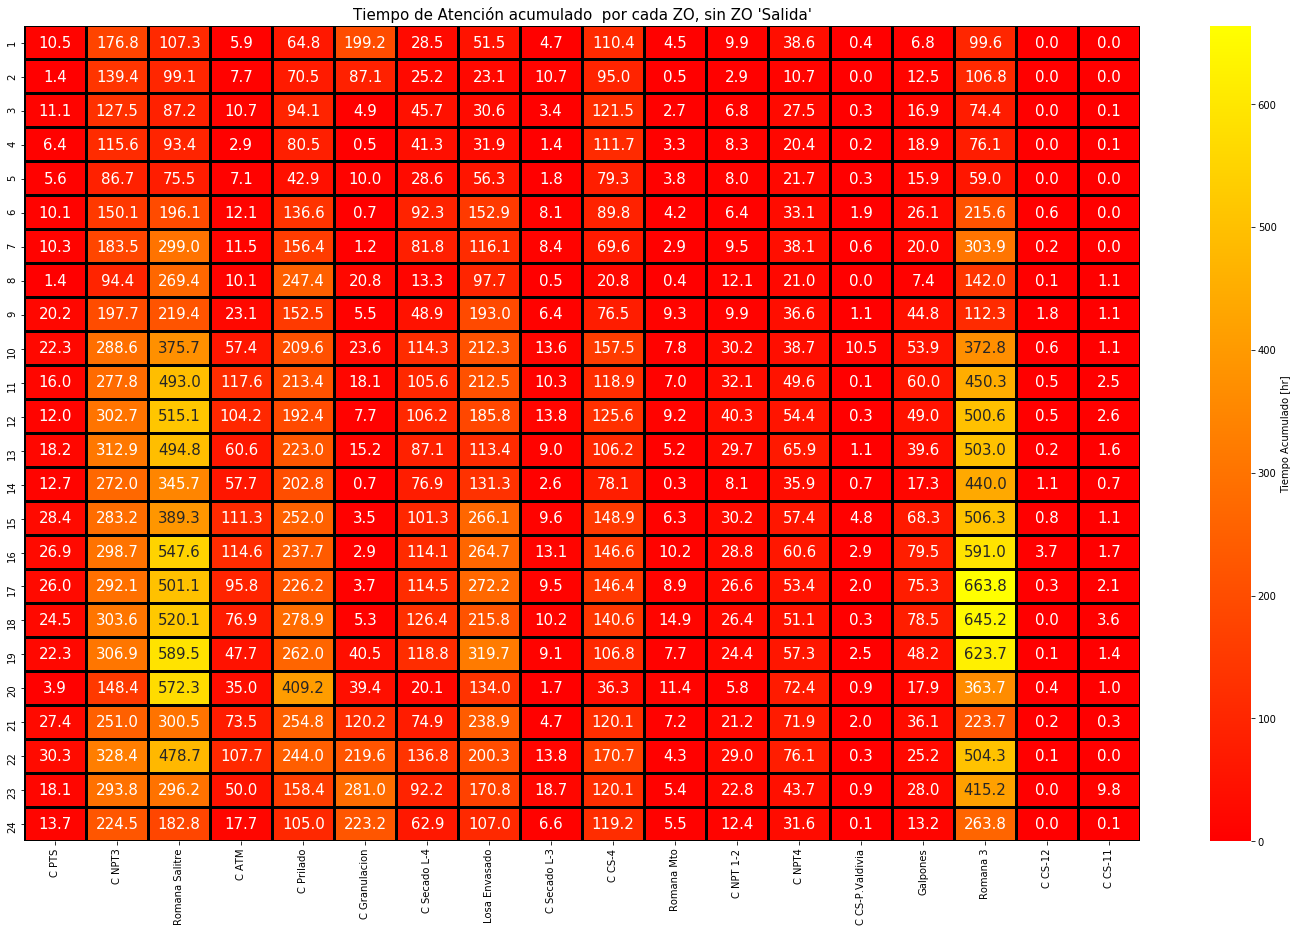

In [93]:
def vehiculos_time_2(inicio=1,fin=25):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos ingresados} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(start,end)
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            cumulative_time = block_filtered.Time.sum()
            if zo in diccionario.keys():
                diccionario[zo].update({i:(cumulative_time/3600)})
            else:
                diccionario.update({zo:{i:(cumulative_time/3600)}})
    return diccionario
zonas_bloques_time_2=vehiculos_time_2()
heat_map_time_2=dict_to_df(zonas_bloques_time_2)
fig, ax = plt.subplots(figsize=(25,15)) 
sns.heatmap(heat_map_time_2.iloc[:,1:],cmap="autumn",linecolor="black", linewidths=2,cbar_kws={'label': 'Tiempo Acumulado [hr]'},
            annot=True, fmt=".1f",annot_kws={"size": 15})
plt.title("Tiempo de Atención acumulado  por cada ZO, sin ZO 'Salida'",fontsize=15)
plt.show()

Es interesante notar la diferencia entre los dos mapas de tiempo. Se ven claramente las siguientes acotaciones:
1. Para la Romana 3 se incrementó el tiempo en casi un triple para los horarios entre 19 y 23 hrs
2. De la misma manera para Losa envasado dentro de las 17 y 22 hrs.

# Promedios, Moda, Media, Max, Min de los tiempos de atención.

Para llevar acabo esto debemos tener un estadístico del día (del año completo), es decir, comprimir el mapa de arriba para obtener datos considerables para cada dataframe


In [66]:
heat_map_time.describe()

Salida      C PTS      C NPT3  Romana Salitre      C ATM  \
count   24.000000  24.000000   24.000000       24.000000  24.000000   
mean   507.048576  13.780174  193.263056      168.599803  21.591354   
std    216.120990   7.674156   65.624686       88.854920  16.301124   
min    179.986667   1.089167   77.093056       34.366667   2.198333   
25%    309.271736   8.841458  140.113819       92.286875   6.362014   
50%    545.192222  13.446389  214.476806      152.378750  19.153472   
75%    701.463403  20.225000  246.801042      257.242361  37.255972   
max    794.621111  26.648056  286.463333      295.280278  49.617778   

        C Prilado  C Granulacion  C Secado L-4  Losa Envasado  C Secado L-3  \
count   24.000000      24.000000     24.000000      24.000000     24.000000   
mean    68.020718       1.689826     64.067789      32.373542      4.709838   
std     32.473546       1.427773     31.643086      19.285370      2.810012   
min     16.563333       0.000000     12.976111       2.248889      0.489167   
25%     43.825972       0.639514     35.491528      15.056250      1.722778   
50%     69.745139       1.309167     75.338056      37.471250      5.306250   
75%     92.620347       2.208472     89.266458      51.071736      6.715972   
max    119.369722       5.727778    113.544722      59.946389      9.642778   

           C CS-4  Romana Mto  C NPT 1-2     C NPT4  C CS-P.Valdivia  \
count   24.000000   24.000000  24.000000  24.000000        24.000000   
mean    80.388785    4.795139  13.887951  33.045185         0.488773   
std     27.874109    2.780765   8.743242  12.808633         0.444482   
min     20.790000    0.207222   1.430833   8.008056         0.000000   
25%     59.270694    2.967639   6.155764  24.711806         0.176181   
50%     90.133194    4.899167  13.706528  31.822083         0.308889   
75%     98.965556    6.494583  21.467153  43.111042         0.701458   
max    117.227500   10.318056  28.669722  56.735556         1.562778   

        Galpones    Romana 3    C CS-12    C CS-11  
count  24.000000   24.000000  24.000000  24.000000  
mean   12.322326  124.855463   0.237060   0.673009  
std     7.779915   71.859515   0.333373   0.782577  
min     0.948056   13.205278   0.000000   0.000000  
25%     5.960764   51.510347   0.033542   0.042083  
50%    11.829444  128.230556   0.128333   0.242639  
75%    16.946250  194.768403   0.220278   1.327569  
max    29.745556  229.268611   1.213889   2.406389

### Promedios

1. Vehículos que salen dentro del mismo bloque

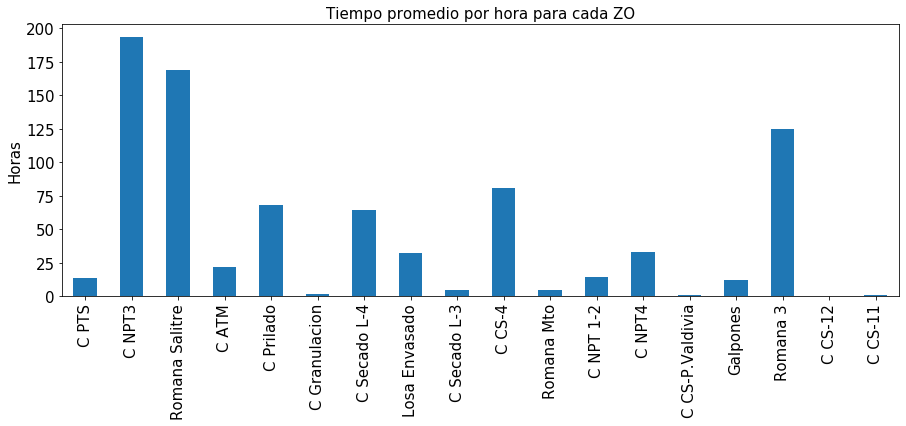

In [94]:
heat_map_time.iloc[:,1:].mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo promedio por hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

2. Vehículos que no salen necesaiamente en el mismo bloque

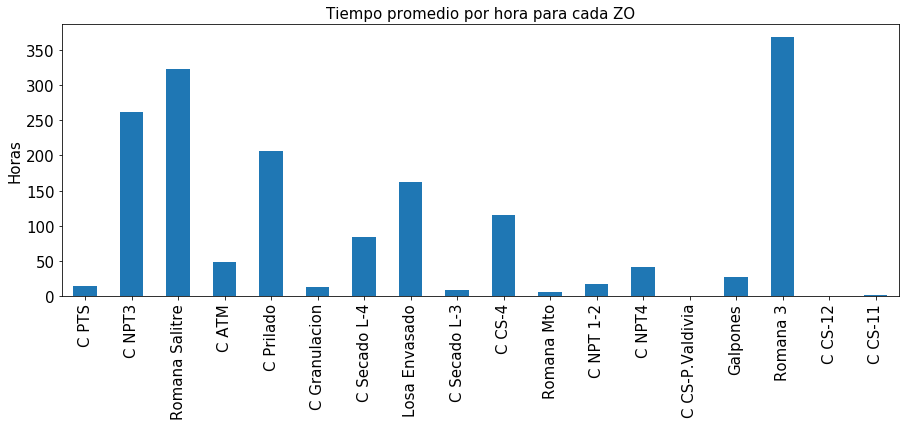

In [109]:
heat_map_time_2.iloc[:,1:].mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo promedio por hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

## Moda

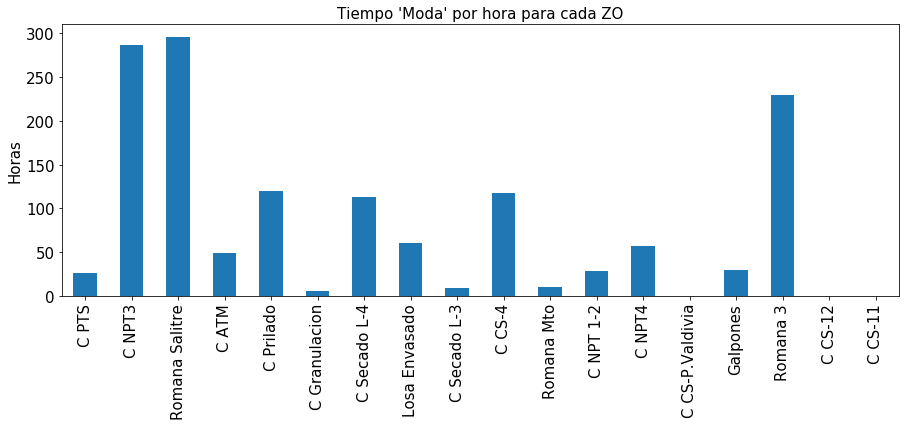

In [107]:
heat_map_time.mode().iloc[-1,1:].plot(kind="bar",figsize=(15,5),fontsize=15)
plt.title("Tiempo 'Moda' por hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

## Media

In [113]:
heat_map_time.iloc[:,1:].median().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo medio por hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

In [117]:
heat_map_time_2.iloc[:,1:].median().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo medio por hora para cada ZO, automoviles que puede que no hayan salido dentro del bloque horario",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

## Maximos y Mínimos

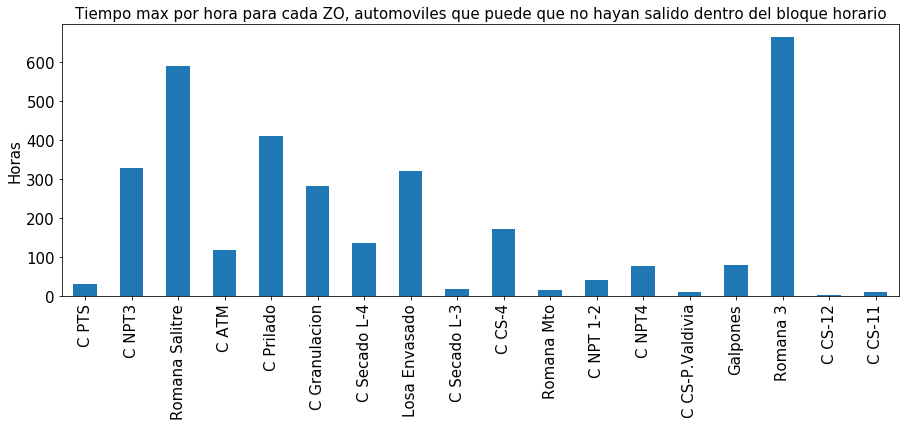

In [118]:
heat_map_time_2.iloc[:,1:].max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo max por hora para cada ZO, automoviles que puede que no hayan salido dentro del bloque horario",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

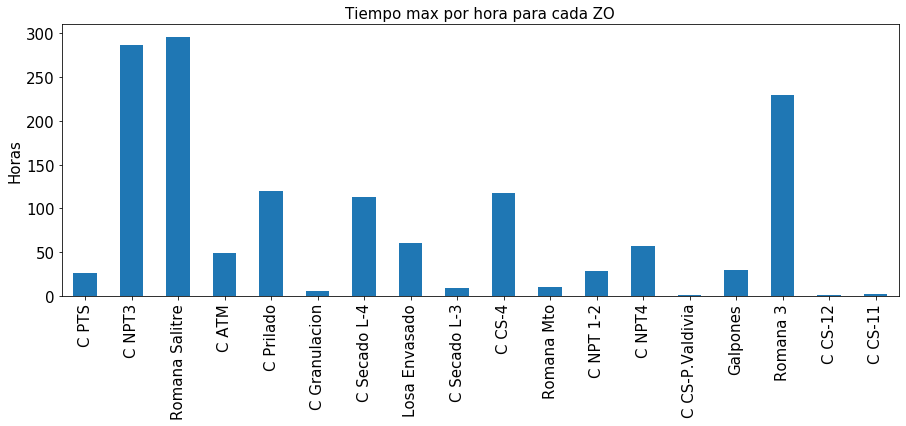

In [119]:
heat_map_time.iloc[:,1:].max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo max por hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

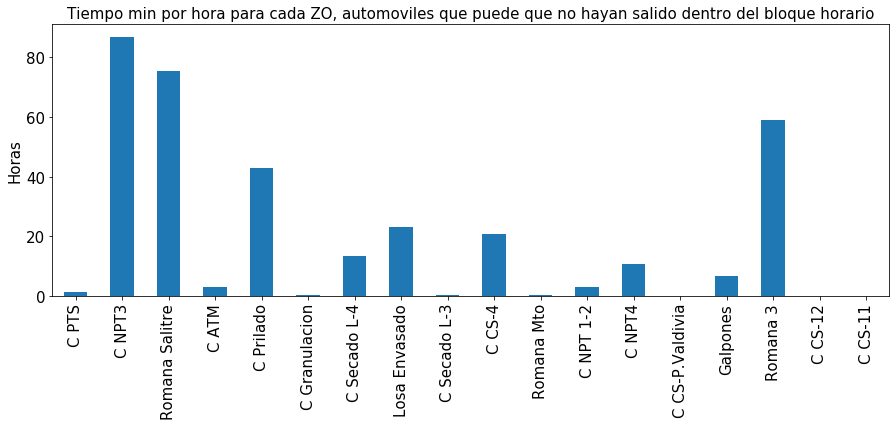

In [120]:
heat_map_time_2.iloc[:,1:].min().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo min por hora para cada ZO, automoviles que puede que no hayan salido dentro del bloque horario",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

In [121]:
heat_map_time.iloc[:,1:].min().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Tiempo max por hora para cada ZO, automoviles que puede que no hayan salido dentro del bloque horario",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

# Promedio, max, min de vehículos en atención

In [136]:
heat_map_out.describe(percentiles = [.98,0.65]).iloc[1:,1:]

C PTS       C NPT3  Romana Salitre       C ATM   C Prilado  \
mean  124.583333  1677.000000      815.083333   98.166667  339.750000   
std    67.276791   543.238197      373.055063   72.561618  163.089533   
min     9.000000   683.000000      193.000000   10.000000   79.000000   
50%   118.500000  1804.000000      769.000000   81.500000  357.500000   
65%   167.550000  2042.700000     1049.400000  150.800000  407.150000   
98%   224.720000  2395.100000     1292.700000  213.960000  578.240000   
max   233.000000  2448.000000     1295.000000  225.000000  581.000000   

      C Granulacion  C Secado L-4  Losa Envasado  C Secado L-3      C CS-4  \
mean       8.250000    485.708333      89.500000     26.208333  558.750000   
std        4.214365    240.109844      51.385161     14.820606  160.861607   
min        0.000000    119.000000       7.000000      5.000000  179.000000   
50%        8.500000    556.500000     107.000000     35.500000  625.000000   
65%        9.950000    607.400000     126.800000     37.000000  649.750000   
98%       16.080000    853.440000     159.540000     44.080000  755.240000   
max       17.000000    870.000000     160.000000     45.000000  758.000000   

      Romana Mto   C NPT 1-2      C NPT4  C CS-P.Valdivia    Galpones  \
mean   71.583333  103.625000  296.791667         4.500000   51.583333   
std    37.824442   62.193815  114.056805         3.683099   32.040622   
min     3.000000   12.000000   83.000000         0.000000    7.000000   
50%    76.500000   95.000000  290.000000         3.000000   47.500000   
65%    91.350000  146.600000  338.600000         4.950000   55.950000   
98%   126.100000  204.340000  498.640000        13.000000  112.720000   
max   133.000000  214.000000  529.000000        13.000000  121.000000   

         Romana 3   C CS-12    C CS-11  
mean   644.041667  2.291667   5.083333  
std    306.509022  2.216130   6.170876  
min     81.000000  0.000000   0.000000  
50%    700.000000  1.500000   1.000000  
65%    824.550000  3.000000   7.700000  
98%   1019.240000  7.620000  17.540000  
max   1022.000000  9.000000  18.000000

In [137]:
heat_map_in.describe(percentiles = [.98,0.65]).iloc[1:,1:]

C PTS       C NPT3  Romana Salitre       C ATM   C Prilado  \
mean  139.375000  1898.083333     1137.166667  143.666667  493.000000   
std    76.321296   628.678525      510.421281  105.764984  209.474913   
min    11.000000   757.000000      289.000000   18.000000  141.000000   
50%   130.000000  2069.000000     1085.500000  121.000000  500.000000   
65%   187.200000  2330.050000     1475.350000  214.100000  565.650000   
98%   254.100000  2686.700000     1801.180000  313.040000  792.220000   
max   261.000000  2735.000000     1809.000000  325.000000  812.000000   

      C Granulacion  C Secado L-4  Losa Envasado  C Secado L-3      C CS-4  \
mean      18.083333    558.041667     219.791667     33.708333  659.625000   
std       12.645386    271.653308     114.368200     19.324414  190.004763   
min        3.000000    122.000000      30.000000      5.000000  179.000000   
50%       14.000000    613.500000     231.000000     41.000000  708.000000   
65%       18.950000    712.200000     290.350000     47.850000  772.000000   
98%       47.260000    968.000000     376.480000     58.540000  884.000000   
max       56.000000    991.000000     382.000000     59.000000  884.000000   

      Romana Mto   C NPT 1-2      C NPT4  C CS-P.Valdivia    Galpones  \
mean   76.666667  122.250000  338.708333         5.625000   83.875000   
std    40.338423   73.617844  128.831700         4.441039   51.189599   
min     4.000000   17.000000   94.000000         0.000000   13.000000   
50%    82.500000  113.000000  326.000000         4.500000   70.500000   
65%    93.850000  171.250000  418.300000         6.900000   87.600000   
98%   136.420000  242.160000  551.840000        15.540000  179.940000   
max   147.000000  267.000000  573.000000        16.000000  185.000000   

         Romana 3    C CS-12    C CS-11  
mean   948.583333   2.791667   6.041667  
std    445.410403   2.603996   6.956256  
min    219.000000   0.000000   0.000000  
50%    994.500000   2.500000   2.000000  
65%   1271.350000   3.000000   7.750000  
98%   1567.080000   8.620000  19.000000  
max   1591.000000  10.000000  19.000000

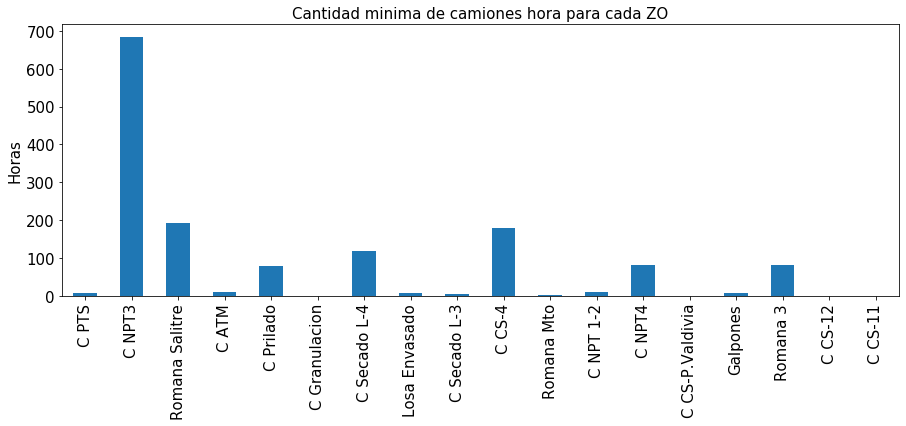

In [138]:
heat_map_out.iloc[:,1:].min().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad minima de camiones hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

In [141]:
heat_map_out.iloc[:,1:].max().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad max de camiones hora para cada ZO, automoviles que puede que no hayan salido dentro del bloque horario",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()

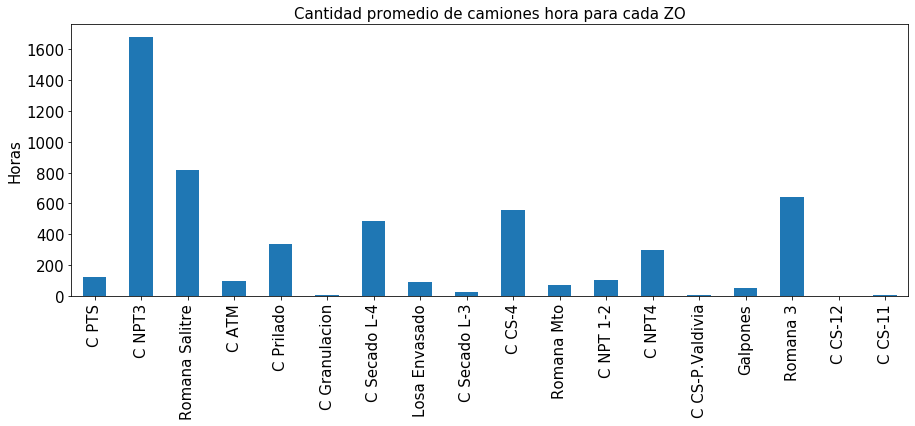

In [142]:
heat_map_out.iloc[:,1:].mean().plot(kind='bar',figsize=(15,5),fontsize=15)
plt.title("Cantidad promedio de camiones hora para cada ZO",fontsize=15)
plt.ylabel("Horas",fontsize=15)
plt.show()